In [23]:
import pandas as pd
import pickle
from sportsreference.ncaab.teams import Teams
from sportsreference.ncaab.conferences import Conferences
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random as rnd
from utils import  score_table
import importlib
from datetime import datetime

#import argparse

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.optim import ClippedAdam
from torch.distributions import constraints

In [35]:
majorConfs = ["big-12","Big 12",
              "big-10","Big Ten","big-ten",
              "sec","SEC",
              "big-east","Big East",
              "pac-12","Pac-12",
              "acc","ACC",
              "wcc", "WCC",
              "mwc","MWC",
              "atlantic-10","Atlantic 10"]
confNameNorm = {"Big 12":"big-12",
              "Big Ten":"big-ten",
              "big-ten":"big-ten",
              "SEC":"sec",
              "Big East":"big-east",
              "Pac-12":"pac-12",
              "ACC":"acc",
              "WCC":"wcc",
                "MWC":"mwc",
               "Atlantic 10":"atlantic-10"}
def getDataForTeams(teams) :
    dataset = pd.DataFrame()
    for team in teams:
        if team.conference in majorConfs:
            tgDF = team.schedule.dataframe
            tgDF['team_name'] = team.name
            tgDF['team_conference'] = team.conference
            dataset = pd.concat([dataset,tgDF])     
    return dataset


In [3]:
#execute this cell to grab the data from the site
season_team_list = Teams("2022")
df = getDataForTeams(season_team_list)
compression_opts = dict(method='zip',
                        archive_name='outv3.csv')  
df.to_csv('data/bigconfs2022Season.zip', compression=compression_opts) 
pickle.dump( season_team_list, open( "data/teams2022.p", "wb" ) )

In [57]:
#execute this cell to just load the local files
season_team_list = pickle.load( open( "data/teams2022.p", "rb" ) )
c_opts = dict(method='zip')
df = pd.read_csv('data/bigconfs2022Season.zip',compression='zip')

In [11]:
df.opponent_conference.unique()

array(['CUSA', 'Summit', 'Sun Belt', 'Horizon', 'MAAC', 'MVC', 'ACC',
       'WCC', 'AAC', 'A-Sun', 'A-10', 'SEC', 'Big 12', 'Big West', 'MWC',
       'Pac-12', 'WAC', 'Big East', 'Big Sky', 'Big Ten', 'Southern',
       'Big South', 'Ivy', 'CAA', 'AEC', 'OVC', 'Southland', 'SWAC',
       'MEAC', 'Patriot', 'Non-DI School', 'NEC', 'MAC'], dtype=object)

In [10]:
allConfs = []
for team in season_team_list:
    allConfs.append(team.conference)
set(allConfs)

{'aac',
 'acc',
 'america-east',
 'atlantic-10',
 'atlantic-sun',
 'big-12',
 'big-east',
 'big-sky',
 'big-south',
 'big-ten',
 'big-west',
 'colonial',
 'cusa',
 'horizon',
 'ivy',
 'maac',
 'mac',
 'meac',
 'mvc',
 'mwc',
 'northeast',
 'ovc',
 'pac-12',
 'patriot',
 'sec',
 'southern',
 'southland',
 'summit',
 'sun-belt',
 'swac',
 'wac',
 'wcc'}

In [124]:
df.columns

Index(['Unnamed: 0', 'arena', 'boxscore_index', 'date', 'datetime', 'game',
       'location', 'opponent_abbr', 'opponent_conference', 'opponent_name',
       'opponent_rank', 'overtimes', 'points_against', 'points_for', 'result',
       'season_losses', 'season_wins', 'streak', 'time', 'type', 'team_name',
       'team_conference'],
      dtype='object')

In [22]:
df.date.values

array(['Tue, Nov 9, 2021', 'Fri, Nov 12, 2021', 'Tue, Nov 16, 2021', ...,
       'Sat, Mar 5, 2022', 'Wed, Mar 9, 2022', 'Tue, Mar 15, 2022'],
      dtype=object)

In [25]:
len(df.index)

3254

In [27]:
dformat = '%a, %b %d, %Y'
keepGreaterThanDate = datetime.strptime('Tue, Dec 31, 2021', dformat)

fdf = df.copy()


#only keep games after this date
fdf['date'] = pd.to_datetime(fdf['date'], format=dformat)
fdf = fdf[fdf.date > keepGreaterThanDate]

In [28]:
len(fdf.index)

2030

In [52]:


def replicateSwappingHomeAndAway(df):
    cdf = df.copy()
    swapdf = pd.DataFrame(columns=['Date','HomeTeam','AwayTeam','FTHG','FTAG'])

    swapdf['Date'] = cdf.Date
    swapdf['HomeTeam'] = cdf.AwayTeam
    swapdf['AwayTeam'] = cdf.HomeTeam
    swapdf['FTHG'] = cdf.FTAG
    swapdf['FTAG'] = cdf.FTHG
    
    fdf = pd.concat([cdf,swapdf], axis=0)
    fdf.reset_index(inplace=True, drop=True)
    return fdf

foo = pd.DataFrame({'Date':['monday','tuesday'],
                    'HomeTeam':['msu','uw'],
                    'AwayTeam':['um','purdue'],
                    'FTHG':[99,88],
                    'FTAG':[25,75]})
foobar = replicateSwappingHomeAndAway(foo)
foobar

,Date,HomeTeam,AwayTeam,FTHG,FTAG
0,monday,msu,um,99,25
1,tuesday,uw,purdue,88,75
2,monday,um,msu,25,99
3,tuesday,purdue,uw,75,88


In [123]:
df = pd.read_csv('data/bigconfs2022Season.zip',compression='zip')
#keepConfs = majorConfs
keepConfs = ["big-10","Big Ten","big-ten",
            "big-12","Big 12",
            "sec","SEC",
              "big-east","Big East",
              "pac-12","Pac-12"]
keepConfs = ["big-10","Big Ten","big-ten",
            "big-12","Big 12",
            "sec","SEC",
              "big-east","Big East",
              "acc","acc"]

dformat = '%a, %b %d, %Y'
keepGreaterThanDate = datetime.strptime('Tue, Dec 31, 2021', dformat)

bdf = df.copy()


#only keep games after this date
bdf['date'] = pd.to_datetime(bdf['date'], format=dformat)
bdf = bdf[bdf.date > keepGreaterThanDate]


#only have games between big conferences
bdf = bdf[(bdf["opponent_conference"].isin(keepConfs)) & 
         (bdf["team_conference"].isin(keepConfs)) ]

#get rid of duplicates
bdf.drop_duplicates(subset='boxscore_index', keep="first")
#drop Neutral games for now
ndf = bdf[bdf["location"] == 'Neutral']
bdf = bdf[bdf["location"].isin(["Home","Away"])]

#create Home, Away, neutral indicator columns
bdf = pd.get_dummies(bdf,prefix=['location'], columns = ['location'])
#create homeTeam, awayTeam columns
def addHomeTeamColumn(row):
    if(row['location_Home'] == 1):
        return row['team_name']
    else:
        return row['opponent_name']
bdf['HomeTeam'] = bdf.apply(addHomeTeamColumn, axis=1)
def addAwayTeamColumn(row):
    if(row['location_Away'] == 1):
        return row['team_name']
    else:
        return row['opponent_name']
bdf['AwayTeam'] = bdf.apply(addAwayTeamColumn, axis=1)
#add in "HomePoints" , AwayPoints
def addHomePointsColumn(row):
    if(row['location_Home'] == 1):
        return row['points_for']
    else:
        return row['points_against']
bdf['HomePoints'] = bdf.apply(addHomePointsColumn, axis=1)
def addAwayPointsColumn(row):
    if(row['location_Away'] == 1):
        return row['points_for']
    else:
        return row['points_against']
bdf['AwayPoints'] = bdf.apply(addAwayPointsColumn, axis=1)

#neutral games; double them with swapped home and away
selector_neut = {'date':'Date', 'team_name':'HomeTeam', 'opponent_name':'AwayTeam',
              'points_for':'FTHG', 'points_against':'FTAG'}
ndf = ndf.rename(columns=selector_neut)[selector_neut.values()]
ndf.reset_index(inplace=True,drop=True)
ndfd = replicateSwappingHomeAndAway(ndf)



#just big ten conference games
big10df = bdf.loc[(bdf["team_conference"]=='big-ten')&
                  (bdf['opponent_conference']=='Big Ten')]

#rename columns
selector_d = {'date':'Date', 'HomeTeam':'HomeTeam', 'AwayTeam':'AwayTeam',
              'HomePoints':'FTHG', 'AwayPoints':'FTAG'}
bdf = bdf.rename(columns=selector_d)[selector_d.values()]
bdf.reset_index(inplace=True, drop=True)
big10df = big10df.rename(columns=selector_d)[selector_d.values()]
big10df.reset_index(inplace=True, drop=True)

bdfd = replicateSwappingHomeAndAway(bdf)
big10dfd = replicateSwappingHomeAndAway(big10df)
bdfplusN = pd.concat([bdf,ndf],axis=0)
bdfplusN.reset_index(inplace=True, drop=True)

bdf.head()




,Date,HomeTeam,AwayTeam,FTHG,FTAG
0,2022-01-05,Florida,Alabama,70.0,83.0
1,2022-01-08,Missouri,Alabama,92.0,86.0
2,2022-01-11,Alabama,Auburn,77.0,81.0
3,2022-01-15,Mississippi State,Alabama,78.0,76.0
4,2022-01-19,Alabama,Louisiana State,70.0,67.0


In [60]:
len(bdfplusN.index)

1154

In [194]:
ndfd[ndfd['Date']=='Mon, Nov 22, 2021']

,Date,HomeTeam,AwayTeam,FTHG,FTAG
7,"Mon, Nov 22, 2021",Arkansas,Kansas State,72.0,64.0
21,"Mon, Nov 22, 2021",California,Florida,60.0,80.0
34,"Mon, Nov 22, 2021",Florida,California,80.0,60.0
54,"Mon, Nov 22, 2021",Kansas State,Arkansas,64.0,72.0
90,"Mon, Nov 22, 2021",Northwestern,Providence,72.0,77.0
94,"Mon, Nov 22, 2021",Ohio State,Seton Hall,79.0,76.0
109,"Mon, Nov 22, 2021",Providence,Northwestern,77.0,72.0
118,"Mon, Nov 22, 2021",Seton Hall,Ohio State,76.0,79.0
136,"Mon, Nov 22, 2021",Texas A&M,Wisconsin,58.0,69.0
174,"Mon, Nov 22, 2021",Wisconsin,Texas A&M,69.0,58.0


In [175]:
len(bdf.index)

1256

In [178]:
[len(ndf.index),ndf.date.min()]

[178, 'Fri, Mar 11, 2022']

In [117]:
[len(bdf.index),len(bdfd.index)]

[1798, 3596]

In [6]:
bdf.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG'], dtype='object')

In [132]:
[len(bdfd.HomeTeam.unique()),len(bdfd.AwayTeam.unique())]

[24, 24]

In [33]:
[len(big10df.HomeTeam.unique()),len(big10df.AwayTeam.unique())]

[14, 14]

In [24]:
len(list(set(bdf.HomeTeam.unique().tolist()).union(set(bdf.AwayTeam.unique().tolist()))))

98

In [31]:
def transformData(data):
    pl_data = data

    ng = len(pl_data)  # number of games
    npr = 45  # predict the last 5 rounds of games
    ngob = ng - npr  # number of games to train

    pl_data = pl_data.rename(columns={"FTHG": "score1","FTAG":"score2",
                            "HomeTeam":"Home","AwayTeam":"Away"})

    #teams = pl_data["Home"].unique()
    teams = list(set(pl_data.Home.unique().tolist()).union(set(pl_data.Away.unique().tolist())))
    teams = pd.DataFrame(teams, columns=["Team"])
    teams["i"] = teams.index

    df = pd.merge(pl_data, teams, left_on="Home", right_on="Team", how="left")
    df = df.rename(columns={"i": "Home_id"}).drop("Team", axis=1)
    df = pd.merge(df, teams, left_on="Away", right_on="Team", how="left")
    df = df.rename(columns={"i": "Away_id"}).drop("Team", axis=1)

    print(df.head())

    return teams, df


In [61]:
tt,dd = transformData(bdfplusN)

        Date               Home             Away  score1  score2  Home_id  \
0 2022-01-05            Florida          Alabama    70.0    83.0       31   
1 2022-01-08           Missouri          Alabama    92.0    86.0        2   
2 2022-01-11            Alabama           Auburn    77.0    81.0       25   
3 2022-01-15  Mississippi State          Alabama    78.0    76.0       57   
4 2022-01-19            Alabama  Louisiana State    70.0    67.0       25   

   Away_id  
0       25  
1       25  
2       23  
3       25  
4        4  


In [149]:
tt

,Team,i
0,Virginia,0
1,Mississippi State,1
2,Colorado,2
3,Marquette,3
4,Auburn,4
...,...,...
71,Nebraska,71
72,Utah,72
73,Kansas,73
74,Wake Forest,74


In [95]:
dd.score1.describe()

count    560.000000
mean      70.792857
std       10.745051
min       45.000000
25%       64.000000
50%       70.000000
75%       78.000000
max      110.000000
Name: score1, dtype: float64

In [96]:
h_id = torch.tensor(dd["Home_id"])
a_id = torch.tensor(dd["Away_id"])


[len(list(set(h_id.unique().tolist()).union(set(a_id.unique().tolist())))),len(h_id),len(a_id)
,len(h_id.unique()),len(a_id.unique()) ]

[14, 560, 560, 14, 14]

In [70]:
class FoldedTransform(dist.transforms.AbsTransform):
    def log_abs_det_jacobian(self, x, y):
        return torch.zeros_like(x)

def model(home_id, away_id, score1_obs=None, score2_obs=None):
    # hyperpriors
    alpha = pyro.sample("alpha", dist.Normal(0.0, 1.0))
    sd_att = pyro.sample("sd_att", dist.TransformedDistribution(dist.StudentT(3.0, 0.0, 4), FoldedTransform()))
    sd_def = pyro.sample("sd_def", dist.TransformedDistribution(dist.StudentT(3.0, 0.0, 4), FoldedTransform()))
    #student t: degrees of freedom, mean, width
    #started with width = 2.5
    #home = pyro.sample("home", dist.Normal(0.0, 2.0))  # home advantage
    #started with 1.0 for std

    #this has to be the number of teams!!! 
    #nt = len(np.unique(home_id))
    nt = len(list(set(np.unique(home_id).tolist()).union(set(np.unique(away_id).tolist()))))


    # team-specific model parameters
    with pyro.plate("plate_teams", nt):
        attack = pyro.sample("attack", dist.Normal(0, sd_att))
        defend = pyro.sample("defend", dist.Normal(0, sd_def))

    # likelihood
    theta1 = torch.exp(alpha + attack[home_id] - defend[away_id])
    theta2 = torch.exp(alpha + attack[away_id] - defend[home_id])

    with pyro.plate("data", len(home_id)):
        pyro.sample("s1", dist.Poisson(theta1), obs=score1_obs)
        pyro.sample("s2", dist.Poisson(theta2), obs=score2_obs)

def guide(home_id, away_id, score1_obs=None, score2_obs=None):
    mu_locs = pyro.param("mu_loc", torch.tensor(0.0).expand(3))
    mu_scales = pyro.param("mu_scale", torch.tensor(0.1).expand(3), constraint=constraints.positive)

    pyro.sample("alpha", dist.Normal(mu_locs[0], mu_scales[0]))
    pyro.sample("sd_att", dist.LogNormal(mu_locs[1], mu_scales[1]))
    pyro.sample("sd_def", dist.LogNormal(mu_locs[2], mu_scales[2]))
    #pyro.sample("home", dist.Normal(mu_locs[3], mu_scales[3]))  # home advantage

    nt = len(list(set(np.unique(home_id).tolist()).union(set(np.unique(away_id).tolist()))))
    #nt = len(np.unique(home_id))
    #print("number of teams: ", nt)

    mu_team_locs = pyro.param("mu_team_loc", torch.tensor(0.0).expand(2, nt))
    mu_team_scales = pyro.param("mu_team_scale", torch.tensor(0.1).expand(2, nt), constraint=constraints.positive)

    with pyro.plate("plate_teams", nt):
        pyro.sample("attack", dist.Normal(mu_team_locs[0], mu_team_scales[0]))
        pyro.sample("defend", dist.Normal(mu_team_locs[1], mu_team_scales[1]))

def run_inference(model, guide, home_id, away_id, score1, score2, args):
    gamma = 0.01  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / args.num_iterations)

    svi = SVI(
        model=model,
        guide=guide,
        optim=ClippedAdam({"lr": args.learning_rate, "lrd": lrd}),
        loss=Trace_ELBO(num_particles=args.num_particles),
    )

    pyro.clear_param_store()  # clear global parameter cache
    pyro.set_rng_seed(args.rng_seed)

    advi_loss = []
    for j in range(args.num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(
            home_id=home_id,
            away_id=away_id,
            score1_obs=score1.float(),
            score2_obs=score2.float(),
        )
        advi_loss.append(loss)
        if j % 100 == 0:
            print("[iteration %4d] loss: %.4f" % (j + 1, loss))

    print("Posterior: ")
    for i in pyro.get_param_store().items():
        print(i)

    fit = Predictive(model=model, guide=guide, num_samples=2000)(
        home_id=home_id, away_id=away_id
    )

    return fit

def runThePyroFit(data,args):
    print("transforming data...")
    teams, df =  transformData(data)
    #train = df[df["split"] == "train"]
    train = df

    print("Starting inference...")
    fit = run_inference(
        model,
        guide,
        torch.tensor(train["Home_id"]),
        torch.tensor(train["Away_id"]),
        torch.tensor(train["score1"]),
        torch.tensor(train["score2"]),
        args,
    )
    return fit,teams,df,train

#def runThePyroCodeRest(data,args,fit):
def runThePyroCodeRest(fit,teams,df,train):
#    print("transforming data...")
#    teams, df =  transformData(data)
#    train = df[df["split"] == "train"]

#    print("Starting inference...")
#    fit = run_inference(
#        model,
#        guide,
#        torch.tensor(train["Home_id"]),
#        torch.tensor(train["Away_id"]),
#        torch.tensor(train["score1"]),
#        torch.tensor(train["score2"]),
#        args,
#    )

    print("Analyse posterior...")


    # Predicted goals and table
    #predict = df[df["split"] == "predict"]
    predict = predictDF
    #print("this many home_ids: " , predict.Home_id.unique())

    predictive = Predictive(
        model=model, guide=guide, num_samples=2000, return_sites=["s1", "s2"]
    )
 
    predicted_score = predictive(
        home_id=predict["Home_id"].values,
        away_id=predict["Away_id"].values,
    )

    predicted_full = predict.copy()
    predicted_full = predicted_full.assign(
        score1=predicted_score["s1"].mean(axis=0).round(),
        score1error=predicted_score["s1"].std(axis=0),
        score2=predicted_score["s2"].mean(axis=0).round(),
        score2error=predicted_score["s2"].std(axis=0),
    )

    predicted_full = train.append(
        predicted_full.drop(columns=["score1error", "score2error"])
    )

    print(score_table(df))
    print(score_table(predicted_full))

def qualityCalc(fit,teams,df,train):
    # Attack and defence
    quality = teams.copy()

    quality = quality.assign(
        attack=fit["attack"].mean(axis=0),
        attacksd=fit["attack"].std(axis=0),
        defend=fit["defend"].mean(axis=0),
        defendsd=fit["defend"].std(axis=0),
    )
    quality = quality.assign(
        attack_low=quality["attack"] - quality["attacksd"],
        attack_high=quality["attack"] + quality["attacksd"],
        defend_low=quality["defend"] - quality["defendsd"],
        defend_high=quality["defend"] + quality["defendsd"],
    )
    #gotta debug this
    return quality




In [71]:
class Args():
    learning_rate = 0.1
    num_particles = 1
    rng_seed = 1
    num_iterations = 2000

args=Args()
fit,teams,df,train = runThePyroFit(bdf,args)

transforming data...
        Date               Home             Away  score1  score2  Home_id  \
0 2022-01-05            Florida          Alabama    70.0    83.0       31   
1 2022-01-08           Missouri          Alabama    92.0    86.0        2   
2 2022-01-11            Alabama           Auburn    77.0    81.0       25   
3 2022-01-15  Mississippi State          Alabama    78.0    76.0       57   
4 2022-01-19            Alabama  Louisiana State    70.0    67.0       25   

   Away_id  
0       25  
1       25  
2       23  
3       25  
4        4  
Starting inference...
[iteration    1] loss: 481655.9004
[iteration  101] loss: 8698.9971
[iteration  201] loss: 8288.8776
[iteration  301] loss: 8316.9184
[iteration  401] loss: 8272.0891
[iteration  501] loss: 8245.0448
[iteration  601] loss: 8213.6144
[iteration  701] loss: 8226.6002
[iteration  801] loss: 8218.8161
[iteration  901] loss: 8222.3971
[iteration 1001] loss: 8227.2551
[iteration 1101] loss: 8223.2493
[iteration 1201] l

In [72]:
qDF = qualityCalc(fit,teams,df,train)
qDF.head()

,Team,i,attack,attacksd,defend,defendsd,attack_low,attack_high,defend_low,defend_high
0,Kansas State,0,1.628959,0.018138,-1.723940,0.018567,1.610821,1.647097,-1.742507,-1.705373
1,Iowa,1,1.698427,0.019153,-1.778623,0.020391,1.679274,1.717581,-1.799014,-1.758232
2,Missouri,2,1.545486,0.020870,-1.676324,0.019950,1.524616,1.566356,-1.696273,-1.656374
3,Oklahoma,3,1.589892,0.019727,-1.659904,0.018778,1.570166,1.609619,-1.678682,-1.641125
4,Louisiana State,4,1.640227,0.020020,-1.639423,0.021082,1.620206,1.660247,-1.660505,-1.618341


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'defend strength')

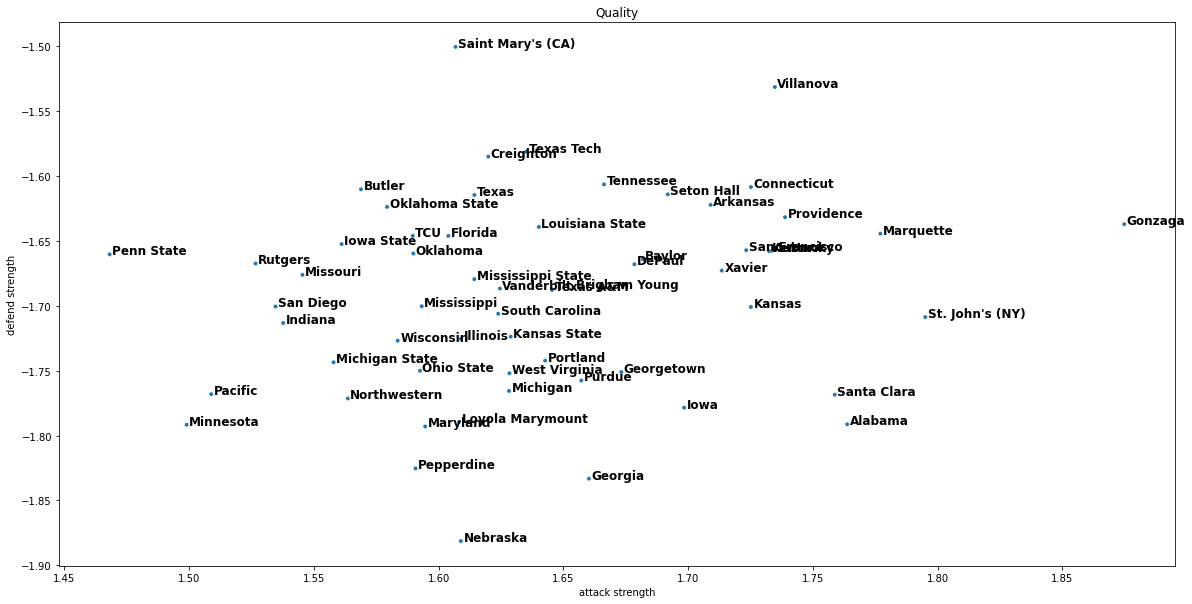

In [73]:

plt.figure(figsize=(20,10))
p1 = sns.scatterplot('attack', # Horizontal axis
       'defend', # Vertical axis
       data=qDF, # Data source
       size = 8,
       legend=False)  

for line in range(0,qDF.shape[0]):
     p1.text(qDF.attack[line]+0.001, qDF.defend[line], 
     qDF.Team[line], horizontalalignment='left', 
     size='large', color='black', weight='semibold')

plt.title('Quality')
# Set x-axis label
plt.xlabel('attack strength')
# Set y-axis label
plt.ylabel('defend strength')

In [94]:
teams[teams['Team']=='Indiana'].i.values[0]

6

In [74]:
teams

,Team,i
0,Kansas State,0
1,Iowa,1
2,Missouri,2
3,Oklahoma,3
4,Louisiana State,4
5,Oklahoma State,5
6,Indiana,6
7,Villanova,7
8,Iowa State,8
9,San Diego,9


In [78]:
[6]+list(teams.i)

[6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58]

In [118]:
tsn = ['Indiana',"Saint Mary's (CA)"]

ts = getGameIndexs(teams,tsn[0],tsn[1])

predictive = Predictive(
    model=model, guide=guide, num_samples=10000, return_sites=["s1", "s2"]
)

def getTeamIndex(ts,name):
    return(ts[ts['Team']==name].i.values[0])
def getGameIndexs(ts,name1,name2):
    return([getTeamIndex(ts,name1),getTeamIndex(ts,name2)])


allTeams = list(teams.i)


                   
AvB = pd.DataFrame({'Home_id':[ts[0]]+allTeams,
        'Away_id':[ts[1]]+allTeams})
predicted_score = predictive(
    home_id=AvB["Home_id"].values,
    away_id=AvB["Away_id"].values,
)

t1scores = predicted_score["s1"][0].tolist()
t2scores = predicted_score["s2"][0].tolist()

#spread and over under distributions
n=500
sams1=rnd.choices(t1scores, k=n)
sams2=rnd.choices(t2scores, k=n)
overunder = [p1+p2 for p1 in sams1 for p2 in sams2]
spread    = [p1-p2 for p1 in sams1 for p2 in sams2]
samsDF = pd.DataFrame({'overunder':overunder,'spread':spread})


Text(0.5, 1.0, "blue:Indiana green:Saint Mary's (CA)")

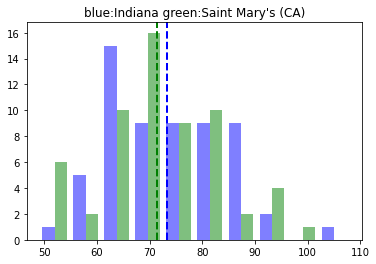

In [119]:

def meanl(lst):
    return sum(lst) / len(lst)
plt.hist([t1scores, t2scores], color=['b','g'], alpha=0.5)
plt.axvline(meanl(t1scores), color='b', linestyle='dashed', linewidth=2)
plt.axvline(meanl(t2scores), color='g', linestyle='dashed', linewidth=2)
plt.title("blue:"+tsn[0]+" green:"+tsn[1])


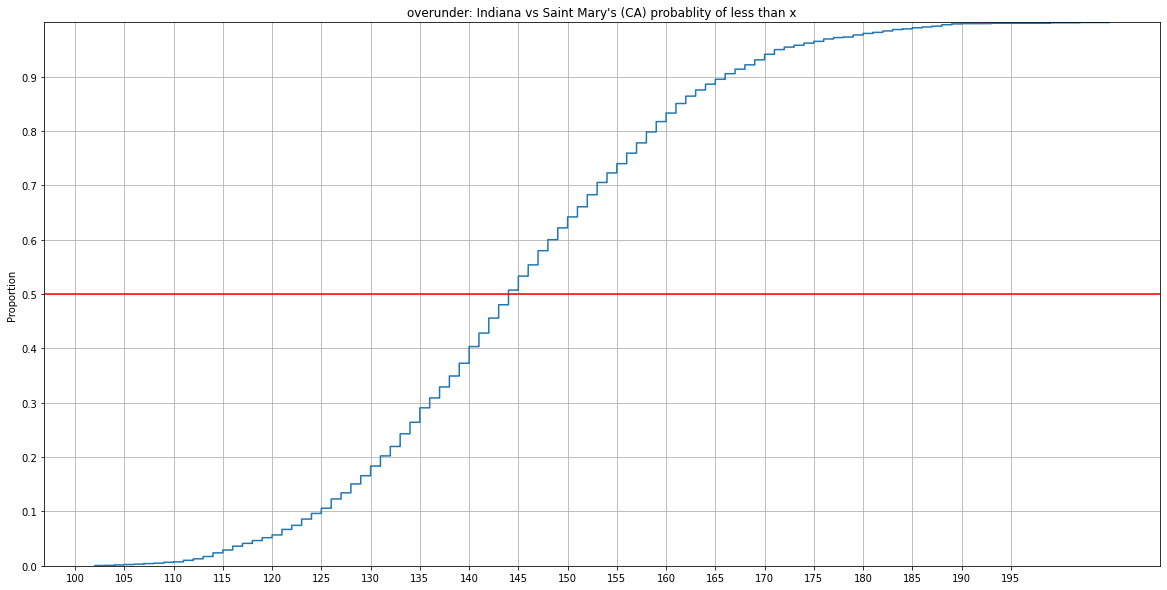

In [121]:
plt.figure(figsize=(20,10))

sns.ecdfplot(overunder)
plt.grid()
plt.xticks(range(100,200,5))
plt.yticks([a/10.0 for a in range(0,10)])
plt.axhline(y=0.5, color='r', linestyle='-')
plt.title("overunder: "+tsn[0]+" vs "+tsn[1]+" probablity of less than x")
plt.savefig('figs/'+tsn[0]+"vs"+tsn[1]+"Overunder.png")

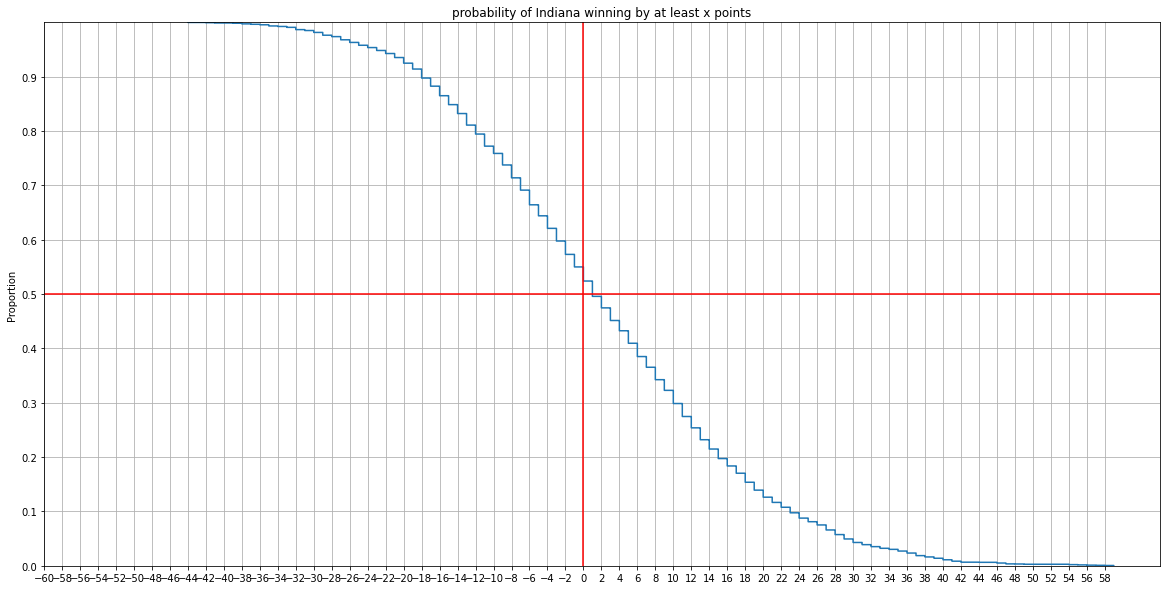

In [122]:
#probability of team1 wining by at least x points
plt.figure(figsize=(20,10))

sns.ecdfplot(spread,complementary=True)
plt.grid()
plt.xticks(range(-60,60,2))
plt.yticks([a/10.0 for a in range(0,10)])
plt.title("probability of "+ tsn[0] + " winning by at least x points")

plt.axhline(y=0.5, color='r', linestyle='-')
plt.axvline(x=0, color='r', linestyle='-')
plt.savefig('figs/'+tsn[0]+"vs"+tsn[1]+"spread.png")